## ライブラリのインポートと初期設定

シミュレーションに必要なPythonライブラリをインポートし、実験の初期設定を行う。

- `numpy`：乱数生成や数値計算に使用。
- `pandas`：データの整形・保存に使用予定。
- `matplotlib.pyplot`：グラフ描画に使用。
- `scipy.stats`：統計処理（信頼区間など）に使用。

### パラメータ設定の内容：
- `np.random.seed(42)`：再現性のある乱数を生成するためのシード値。一般に「42」はSF小説『銀河ヒッチハイク・ガイド』に由来する「究極の答え」として知られ、慣例的に使用されることがある。42以外も可。
- `sample_sizes`：シミュレーションで使用するサンプルサイズのリスト。
- `n_simulations`：各サンプルサイズに対して行うシミュレーション回数（5000回）。
- `confidence`：信頼区間の信頼水準（95%）。
- `true_mean_uniform`：母集団の真の平均（U(0,1) の平均は0.5）。
- `coverage_uniform`：信頼区間の被覆率（真の平均を含む割合）を格納するリスト。


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# 初期設定
np.random.seed(42)
sample_sizes = [5, 10, 30, 50, 100, 200]
n_simulations = 5000
confidence = 0.95
true_mean_uniform = 0.5  # 一様分布 U(0,1) の母平均

coverage_uniform = []  # 結果格納用


## 信頼区間の被覆率を求めるシミュレーション

１．
一様分布 U(0,1) からの標本に対して、t分布を用いて信頼区間を計算し、母平均（0.5）がその信頼区間に含まれる確率（被覆率）を推定するシミュレーションを行う。

### 処理の流れ：

- `for n in sample_sizes:`  
  各サンプルサイズ（5, 10, 30, 50, 100, 200）ごとに繰り返す。

- `count = 0`  
  真の平均が信頼区間に含まれた回数をカウントするための変数。

- `for _ in range(n_simulations):`  
  各サンプルサイズについて5,000回シミュレーションを実行。

- `sample = np.random.uniform(0, 1, n)`  
  大きさ `n` の一様乱数標本を生成。

- `mean = np.mean(sample)`  
  標本平均を計算。

- `std_err = np.std(sample, ddof=1) / np.sqrt(n)`  
  標本標準誤差を計算（不偏標準偏差を使用）。

- `t_crit = stats.t.ppf(1 - (1 - confidence) / 2, df=n - 1)`  
  信頼水準95%に対応するt値（両側）を計算。自由度は n - 1。

- `margin = t_crit * std_err`  
  信頼区間の半幅（マージン）を計算。

- `lower, upper = mean - margin, mean + margin`  
  信頼区間の下限と上限を算出。

- `if lower <= true_mean_uniform <= upper:`  
  真の平均（0.5）が信頼区間に含まれているかどうかを判定。

- `count += 1`  
  含まれていればカウントを増やす。

- `coverage_uniform.append(count / n_simulations)`  
  各サンプルサイズにおける被覆率（含まれていた割合）をリストに格納。


In [18]:
for n in sample_sizes:
    count = 0
    for _ in range(n_simulations):
        sample = np.random.uniform(0, 1, n)
        mean = np.mean(sample)
        std_err = np.std(sample, ddof=1) / np.sqrt(n)
        t_crit = stats.t.ppf(1 - (1 - confidence) / 2, df=n - 1)
        margin = t_crit * std_err
        lower, upper = mean - margin, mean + margin
        if lower <= true_mean_uniform <= upper:
            count += 1
    coverage_uniform.append(count / n_simulations)


## シミュレーション結果のデータフレーム化と表示

各サンプルサイズに対応する信頼区間の被覆率（coverage rate）をPandasのデータフレーム形式にまとめて表示する。

- `pd.DataFrame({...})`：辞書形式で列名とデータを指定し、2列（サンプルサイズと被覆率）からなるデータフレームを作成。
  - `"Sample Size"`：使用した標本サイズ。
  - `"Coverage Rate (Uniform)"`：その標本サイズにおける信頼区間の被覆率（真の母平均0.5を含んだ割合）。

- `print(df_uniform)`：作成したデータフレームをコンソールに出力して、結果を一覧表示する。

In [ ]:
df_uniform = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Coverage Rate (Uniform)": coverage_uniform
})
print(df_uniform)

   Sample Size  Coverage Rate (Uniform)
0            5                   0.9352
1           10                   0.9446
2           30                   0.9470
3           50                   0.9464
4          100                   0.9462
5          200                   0.9546


## 被覆率の誤差を可視化するグラフの描画

信頼区間の理想的な被覆率（95%）との差の絶対値を計算し、それをサンプルサイズごとにプロットして可視化する。

### 主な処理内容：

- `uniform_errors = [abs(c - 0.95) for c in coverage_uniform]`  
  各サンプルサイズで得られた被覆率と理想値0.95との絶対誤差を計算。

- `plt.figure()`  
  新しい図の作成を開始。

- `plt.plot(...)`  
  サンプルサイズに対する絶対誤差を折れ線グラフとして描画。  
  - `marker='o'`：各点を丸印で表示。  
  - `color='blue'`：線の色を青に設定。  
  - `label='Uniform(0,1) Error'`：凡例用のラベル。

- `plt.axhline(0, ...)`  
  y=0 の基準線（理想的な誤差ゼロのライン）を赤い破線で表示。

- `plt.title(...)`  
  グラフタイトル：「Absolute Error from 95% Coverage (Uniform Only)」。

- `plt.xlabel(...)`, `plt.ylabel(...)`  
  横軸を「Sample Size」、縦軸を「Absolute Error |coverage - 0.95|」としてラベリング。

- `plt.ylim(0, max(uniform_errors) + 0.01)`  
  縦軸の範囲を誤差の最大値より少し上まで表示して余白を確保。

- `plt.grid(True)`：背景にグリッド線を表示。

- `plt.legend()`：凡例（ラベル）を表示。

- `plt.tight_layout()`：レイアウトの自動調整。

- `plt.show()`：グラフを画面に表示。


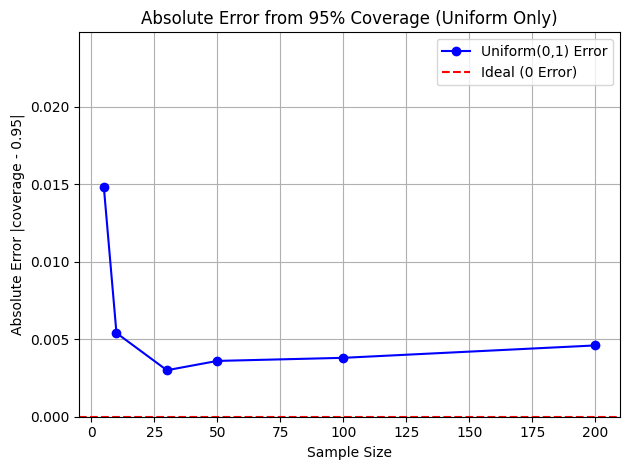

In [20]:
uniform_errors = [abs(c - 0.95) for c in coverage_uniform]

plt.figure()
plt.plot(sample_sizes, uniform_errors, marker='o', color='blue', label='Uniform(0,1) Error')
plt.axhline(0, color='red', linestyle='--', label='Ideal (0 Error)')
plt.title("Absolute Error from 95% Coverage (Uniform Only)")
plt.xlabel("Sample Size")
plt.ylabel("Absolute Error |coverage - 0.95|")
plt.ylim(0, max(uniform_errors) + 0.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


2.
## 指数分布（Exp(1)）に対する被覆率計算の準備

指数分布 Exp(1) を対象としたシミュレーションのための初期設定を行う。

- `true_mean_exponential = 1.0`  
  母集団として扱う指数分布 Exp(1) の真の平均値。指数分布 Exp(λ) の平均は \( \frac{1}{\lambda} \) なので、λ = 1 のとき平均は1となる。

- `coverage_exponential = []`  
  指数分布に対する各サンプルサイズごとの信頼区間の被覆率を格納するための空リスト。


In [ ]:
# 真の平均（指数分布 Exp(1) の平均は 1）
true_mean_exponential = 1.0
coverage_exponential = []

## 指数分布に対する信頼区間の被覆率シミュレーション

指数分布 Exp(1) に対しても、t分布を用いた信頼区間の構築を行い、真の母平均（1.0）がその区間に含まれる割合（被覆率）をシミュレーションによって求める。

### 処理の流れ：

- `for n in sample_sizes:`  
  各サンプルサイズに対してシミュレーションを実行。

- `count = 0`  
  真の平均が信頼区間に含まれた回数をカウントする変数。

- `for _ in range(n_simulations):`  
  各サイズについて5,000回の試行を繰り返す。

- `sample = np.random.exponential(1.0, n)`  
  平均1（λ=1）の指数分布に従うサンプルを `n` 個生成。

- `mean = np.mean(sample)`  
  標本平均を計算。

- `std_err = np.std(sample, ddof=1) / np.sqrt(n)`  
  標本標準誤差を計算（不偏標準偏差を使用）。

- `t_crit = stats.t.ppf(1 - (1 - confidence) / 2, df=n - 1)`  
  自由度 `n-1` のt分布に基づく両側95%信頼区間の臨界値を取得。

- `margin = t_crit * std_err`  
  信頼区間のマージン（半幅）を計算。

- `lower, upper = mean - margin, mean + margin`  
  信頼区間の下限・上限を算出。

- `if lower <= true_mean_exponential <= upper:`  
  真の平均（1.0）が信頼区間に含まれるかを判定。

- `count += 1`  
  含まれていればカウント。

- `coverage_exponential.append(count / n_simulations)`  
  各サンプルサイズにおける被覆率を記録。


In [22]:
for n in sample_sizes:
    count = 0
    for _ in range(n_simulations):
        sample = np.random.exponential(1.0, n)
        mean = np.mean(sample)
        std_err = np.std(sample, ddof=1) / np.sqrt(n)
        t_crit = stats.t.ppf(1 - (1 - confidence) / 2, df=n - 1)
        margin = t_crit * std_err
        lower, upper = mean - margin, mean + margin
        if lower <= true_mean_exponential <= upper:
            count += 1
    coverage_exponential.append(count / n_simulations)


## 指数分布に対するシミュレーション結果のデータフレーム化と表示

指数分布 Exp(1) を用いたシミュレーション結果を、Pandasのデータフレームに整形して表示する。

- `pd.DataFrame({...})`：サンプルサイズと、それに対応する被覆率（信頼区間が母平均1.0を含んだ割合）を列として持つデータフレームを作成。
  - `"Sample Size"`：各シミュレーションで用いた標本サイズ。
  - `"Coverage Rate (Exponential)"`：対応する信頼区間の被覆率。

- `print(df_exponential)`：データフレームの内容をコンソールに出力。


In [23]:
df_exponential = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Coverage Rate (Exponential)": coverage_exponential
})
print(df_exponential)


   Sample Size  Coverage Rate (Exponential)
0            5                       0.8856
1           10                       0.9004
2           30                       0.9330
3           50                       0.9372
4          100                       0.9422
5          200                       0.9450


## 被覆率の誤差を可視化するグラフの描画（指数分布）

指数分布 Exp(1) における信頼区間の被覆率と理想値95%との差（絶対誤差）を、サンプルサイズごとに可視化する。

### 主な処理内容：

- `exponential_errors = [abs(c - 0.95) for c in coverage_exponential]`  
  被覆率と理想値0.95との差の絶対値を計算し、誤差リストを作成。

- `plt.figure()`  
  新しいグラフを作成。

- `plt.plot(...)`  
  サンプルサイズと絶対誤差を折れ線グラフとして描画。  
  - `marker='o'`：各点に丸印を表示。  
  - `color='orange'`：線の色をオレンジに設定。  
  - `label='Exponential(1) Error'`：凡例用のラベル。

- `plt.axhline(0, ...)`  
  y=0 の基準線を赤い破線で描画（理想的な誤差ゼロの基準線）。

- `plt.title(...)`  
  グラフタイトル：「Absolute Error from 95% Coverage (Exponential Only)」。

- `plt.xlabel(...)`, `plt.ylabel(...)`  
  横軸は「Sample Size」、縦軸は「Absolute Error |coverage - 0.95|」。

- `plt.ylim(0, max(exponential_errors) + 0.01)`  
  縦軸の範囲を最大誤差よりやや上に設定して余白を確保。

- `plt.grid(True)`：背景にグリッド線を表示。

- `plt.legend()`：凡例を表示。

- `plt.tight_layout()`：レイアウトを自動で調整。

- `plt.show()`：グラフを画面に表示。


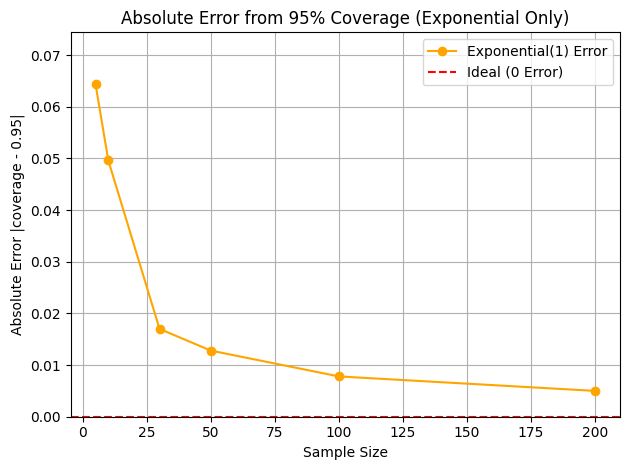

In [24]:
exponential_errors = [abs(c - 0.95) for c in coverage_exponential]

plt.figure()
plt.plot(sample_sizes, exponential_errors, marker='o', color='orange', label='Exponential(1) Error')
plt.axhline(0, color='red', linestyle='--', label='Ideal (0 Error)')
plt.title("Absolute Error from 95% Coverage (Exponential Only)")
plt.xlabel("Sample Size")
plt.ylabel("Absolute Error |coverage - 0.95|")
plt.ylim(0, max(exponential_errors) + 0.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


3.
## 一様分布と指数分布の誤差を比較するデータフレームの作成と表示

このセルでは、一様分布と指数分布それぞれにおける信頼区間の被覆率の誤差（|coverage − 0.95|）を比較できるように、データフレーム形式で整理・表示する。

- `pd.DataFrame({...})`：3列からなる比較用データフレームを作成。
  - `"Sample Size"`：使用したサンプルサイズ。
  - `"Uniform Error"`：一様分布における被覆率の絶対誤差。
  - `"Exponential Error"`：指数分布における被覆率の絶対誤差。

- `print(df_compare)`：作成した比較データフレームをコンソールに表示し、誤差の傾向を数値として確認できるようにする。

In [26]:
df_compare = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Uniform Error": [abs(c - 0.95) for c in coverage_uniform],
    "Exponential Error": [abs(c - 0.95) for c in coverage_exponential]
})
print(df_compare)


   Sample Size  Uniform Error  Exponential Error
0            5         0.0148             0.0644
1           10         0.0054             0.0496
2           30         0.0030             0.0170
3           50         0.0036             0.0128
4          100         0.0038             0.0078
5          200         0.0046             0.0050


## 一様分布と指数分布における被覆率誤差の比較グラフ

一様分布 \( \mathrm{U}(0,1) \) と指数分布 \( \mathrm{Exp}(1) \) における信頼区間の被覆率の誤差（|coverage − 0.95|）を、サンプルサイズごとに比較して折れ線グラフとして可視化する。

### 主な処理内容：

- `plt.plot(...)`（2回）  
  - 一様分布の誤差を青い折れ線（丸印付き）で描画。  
  - 指数分布の誤差をオレンジ色の折れ線（丸印付き）で描画。

- `plt.axhline(0, ...)`  
  y=0 の基準線を赤い破線で描画（理想的な誤差ゼロの基準ライン）。

- `plt.title(...)`  
  グラフタイトル：「Comparison of Coverage Error (|coverage − 0.95|)」。

- `plt.xlabel(...)`, `plt.ylabel(...)`  
  横軸は「Sample Size」、縦軸は「Absolute Error」。

- `plt.ylim(...)`  
  縦軸の範囲を、2分布の誤差の最大値に0.01を加えた値までに設定し、視認性を向上。

- `plt.grid(True)`：グリッド線を表示。

- `plt.legend()`：凡例を表示し、分布ごとの誤差を識別可能にする。

- `plt.tight_layout()`：レイアウトの自動調整。

- `plt.show()`：グラフを画面に描画。


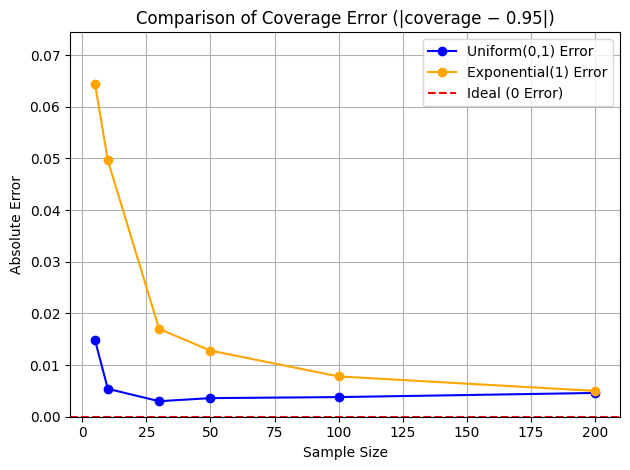

In [27]:
plt.figure()
plt.plot(sample_sizes, df_compare["Uniform Error"], marker='o', label='Uniform(0,1) Error', color='blue')
plt.plot(sample_sizes, df_compare["Exponential Error"], marker='o', label='Exponential(1) Error', color='orange')
plt.axhline(0, color='red', linestyle='--', label='Ideal (0 Error)')
plt.title("Comparison of Coverage Error (|coverage − 0.95|)")
plt.xlabel("Sample Size")
plt.ylabel("Absolute Error")
plt.ylim(0, max(df_compare[["Uniform Error", "Exponential Error"]].max()) + 0.01)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
